In [1]:
import os, re
import torch
import pandas as pd
from PIL import Image
from pathlib import Path
from itertools import islice
from torchvision import transforms
from torch.utils.data import Dataset
from datasets import load_dataset
from collections import defaultdict
from diffusers import StableDiffusionPipeline
from huggingface_hub import hf_hub_download

import matplotlib.pyplot as plt

%matplotlib inline

space =  '    '
branch = '│   '
tee =    '├── '
last =   '└── '

In [2]:
## Format
## git clone https://<your_username>:<your_access_token>@huggingface.co/<user_or_organization>/<repository_name>.git

In [3]:
parent_dir = "../data/Defect_Spectrum/"
os.listdir(parent_dir)

['DS-Cotton-Fabric',
 'DS-DAGM',
 'DS-MVTec',
 'DS-VISION',
 'README.md',
 'synthetic_Cotton_Fabric',
 'synthetic_MVTec',
 'synthetic_VISION']

In [4]:
## checking directory structure
def tree(dir_path: Path, level: int=-1, limit_to_directories: bool=False,
         length_limit: int=1000):
    """Given a directory Path object print a visual tree structure"""
    dir_path = Path(dir_path) # accept string coerceable to Path
    files = 0
    directories = 0
    def inner(dir_path: Path, prefix: str='', level=-1):
        nonlocal files, directories
        if not level: 
            return # 0, stop iterating
        if limit_to_directories:
            contents = [d for d in dir_path.iterdir() if d.is_dir()]
        else: 
            contents = list(dir_path.iterdir())
        pointers = [tee] * (len(contents) - 1) + [last]
        for pointer, path in zip(pointers, contents):
            if path.is_dir():
                yield prefix + pointer + path.name
                directories += 1
                extension = branch if pointer == tee else space 
                yield from inner(path, prefix=prefix+extension, level=level-1)
            elif not limit_to_directories:
                yield prefix + pointer + path.name
                files += 1
    print(dir_path.name)
    iterator = inner(dir_path, level=level)
    for line in islice(iterator, length_limit):
        print(line)
    if next(iterator, None):
        print(f'... length_limit, {length_limit}, reached, counted:')
    print(f'\n{directories} directories' + (f', {files} files' if files else ''))

In [5]:
tree(Path.cwd() / "../data/Defect_Spectrum/DS-MVTec/", level=3)

DS-MVTec
├── bottle
│   ├── image
│   │   ├── broken_large
│   │   ├── broken_small
│   │   ├── contamination
│   │   └── good
│   ├── mask
│   │   ├── broken_large
│   │   ├── broken_small
│   │   └── contamination
│   └── rbg_mask
│       ├── broken_large
│       ├── broken_small
│       └── contamination
├── cable
│   ├── image
│   │   ├── bent_wire
│   │   ├── cable_swap
│   │   ├── combined
│   │   ├── cut_inner_insulation
│   │   ├── cut_outer_insulation
│   │   ├── good
│   │   ├── missing_cable
│   │   ├── missing_wire
│   │   └── poke_insulation
│   ├── mask
│   │   ├── bent_wire
│   │   ├── cable_swap
│   │   ├── combined
│   │   ├── cut_inner_insulation
│   │   ├── cut_outer_insulation
│   │   ├── missing_cable
│   │   ├── missing_wire
│   │   └── poke_insulation
│   └── rgb_mask
│       ├── bent_wire
│       ├── cable_swap
│       ├── combined
│       ├── cut_inner_insulation
│       ├── cut_outer_insulation
│       ├── missing_cable
│       ├── missing_wire
│       └── pok

## EDA on basic DS-Cotton-Fabric

In [6]:
material_name = "DS-Cotton-Fabric"
image_names = os.listdir(f"../data/Defect_Spectrum/{material_name}/image/")
mask_names = os.listdir(f"../data/Defect_Spectrum/{material_name}/mask/")
rbg_mask_names = os.listdir(f"../data/Defect_Spectrum/{material_name}/rbg_mask/")
print(len(image_names), len(mask_names), len(rbg_mask_names))

defect_categories = {}
for fname in image_names:
    category = fname.split("_")[-1].split(".")[0]
    if category not in defect_categories:
        defect_categories[category] = 1
    else:
        defect_categories[category] += 1

print(defect_categories)

## mapping image with mask names 
img2mask_map = {}
for i, m, rbgm in zip(image_names, mask_names, rbg_mask_names):
    unique_id_img = "".join(i.split("_")[:2])
    unique_id_mask = "".join(m.split("_")[:2])
    unique_id_rbg_mask = "".join(rbgm.split("_")[:2])
    if unique_id_img == unique_id_mask == unique_id_rbg_mask:
        img2mask_map[i] = [m, rbgm]

print(len(img2mask_map))

86 86 86
{'Slubs': 4, 'Knots': 5, 'Harness-Misdraw': 1, 'Open-Reed': 2, 'Slack-End': 2, 'Coarse-End': 1, 'End-Out': 3, 'Flat-Harness-Misdraw': 1, 'Harness-Breakdown': 2, 'Thick-Place': 2, 'Dropped-Picks': 1, 'Soiled-Filling': 1, 'Sluggy-Filling': 1, 'Thin-Place': 2, 'Warp-Burl': 1, 'Jerk-In': 1, 'Coarse-Pick': 3, 'Burl': 3, 'Broken-Pick': 2, 'Sloughed-Filling': 2, 'Harness-Balk': 1, 'Mispick': 4, 'Shed-Split': 2, 'Overshot': 1, 'Undershot': 1, 'Slubby-Filling': 1, 'Broken-End': 1, 'Foreign-Fiber': 1, 'Soiled-End': 1, 'Hang-Thread': 1, 'Mat-up': 1, 'Burl-Mark': 2, 'Gouts': 1, 'Warp-Floats': 1, 'Wild-Filling': 1, 'Loom-Waste': 1, 'Smash': 1, 'Knot': 3, 'Warp-Slub': 2, 'Filling-Slub': 1, 'Corrugation': 1, 'Oil-Spot': 2, 'Crease-Streak': 1, 'Crease-Sueded': 1, 'Clip-Mark': 1, 'Water-Damage': 1, 'Rollup-Creases': 1, 'Mixed-Yarn': 1, 'Run': 1, 'Compactor-Creases': 1, 'Slub': 1, 'Hole': 2, 'Tucking-Unwanted': 1, 'Dropped-Stitches': 2, 'Press-Off': 1}
86


## Using "DS-MVTec" for data loader with captions

In [12]:
class DefectSpectrumDataset(Dataset):
    def __init__(self, excel_file, root_dir, transform=None):
        """
        Args:
            excel_file (string): Path to the Excel file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_frame = pd.read_excel(excel_file)  # if csv use pd.read_csv()
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.item()

        img_relative_path = self.data_frame.iloc[idx, 0].split("/")  # First column: 'Path'
        img_relative_path = img_relative_path[0] + "/image/" + "/".join(img_relative_path[1:])
        img_path = self.root_dir+ "/"+ img_relative_path 
        
        image = Image.open(img_path).convert('RGB')
        
        object_description = self.data_frame.iloc[idx, 1]  # Second column: 'Object Description'
        defect_description = self.data_frame.iloc[idx, 2]  # Third column: 'Defect Description'
        
        if self.transform:
            image = self.transform(image)
        
        sample = {
            'image': image,
            'object_description': object_description,
            'defect_description': defect_description
        }
        
        return sample

In [13]:
dataset = DefectSpectrumDataset(
    excel_file='../data/Defect_Spectrum/DS-MVTec/captions.xlsx',
    root_dir='../data/Defect_Spectrum/DS-MVTec',
    transform=transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]) )

D:\Python\siemens-rag-bot\env\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..0.7019608].


In the image is a white pill with the engraving "FF" on it, against a black background. 

The lower half of the white pill has a foreign object defect, shaped irregularly, colored gray.


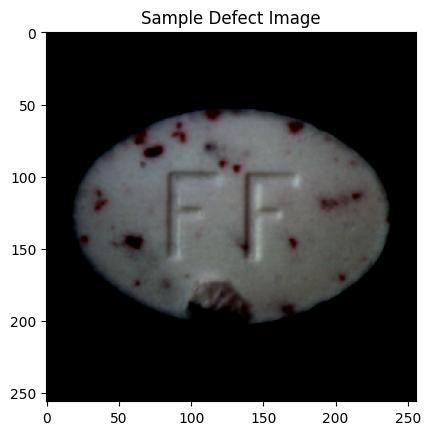

In [14]:
sample = dataset[150]
print(sample['object_description'], "\n")

print(sample['defect_description'])

plt.imshow(sample['image'].permute(1, 2, 0))  # if tensor
plt.title("Sample Defect Image")
plt.show()